<a href="https://colab.research.google.com/github/lanyu0322/Diabetes_Care_Quality_Assessment/blob/main/healthcare_quality_evalution_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/medicare_projects

/content/drive/My Drive/medicare_projects


research goal: The phenomenon of patients being rehospitalized shortly after their initial discharge, particularly in cases of diabetes, has significant implications for healthcare quality and cost management. This issue has prompted initiatives like those from the Centers for Medicare & Medicaid Services, who seek to mitigate healthcare expenses and enhance care quality by penalizing hospitals with unexpectedly high readmission rates for certain medical conditions. Despite diabetes not being a current focus for these penalties, its financial burden is notable; in 2011, the cost attributed to the readmission of diabetic patients within a 30-day period post-discharge was over $41 billion in the U.S. Understanding the factors that contribute to these readmissions is crucial for reducing costs and improving patient outcomes. Our analysis, leveraging a dataset of medical claims, aims to uncover:

The primary factors that influence the likelihood of diabetic patients being readmitted to the hospital.
The potential for accurately forecasting such readmissions in diabetic cases based on a dataset with a limited range of features.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:

plt.rcParams["figure.figsize"] = (15, 10)


# get an overview of the data


In [ ]:
# -- loading Dataset
dia = pd.read_csv("diabetic_data.csv")
dia.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


It contains several columns, including patient demographics (race, gender, age, weight), healthcare encounter details (admission_type_id, discharge_disposition_id, admission_source_id, time_in_hospital), and various medical attributes and treatments.

The readmitted column, which indicates whether the patient was readmitted or not, is a key focus for our analysis.

In [ ]:
# -- print the data type
dia.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

The dataset includes both numerical and categorical columns.
Some columns like race, gender, age, weight, payer_code, and medical_specialty are categorical.
Columns such as time_in_hospital, num_lab_procedures, num_procedures, and num_medications are numerical.

**missing value**

Missing Values Count:
 weight                      98569
medical_specialty           49949
payer_code                  40256
race                         2273
diag_3                       1423
diag_2                        358
diag_1                         21
encounter_id                    0
tolazamide                      0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
citoglipton                     0
examide                         0
acetohexamide                   0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
glipizide                       0
repaglinide              

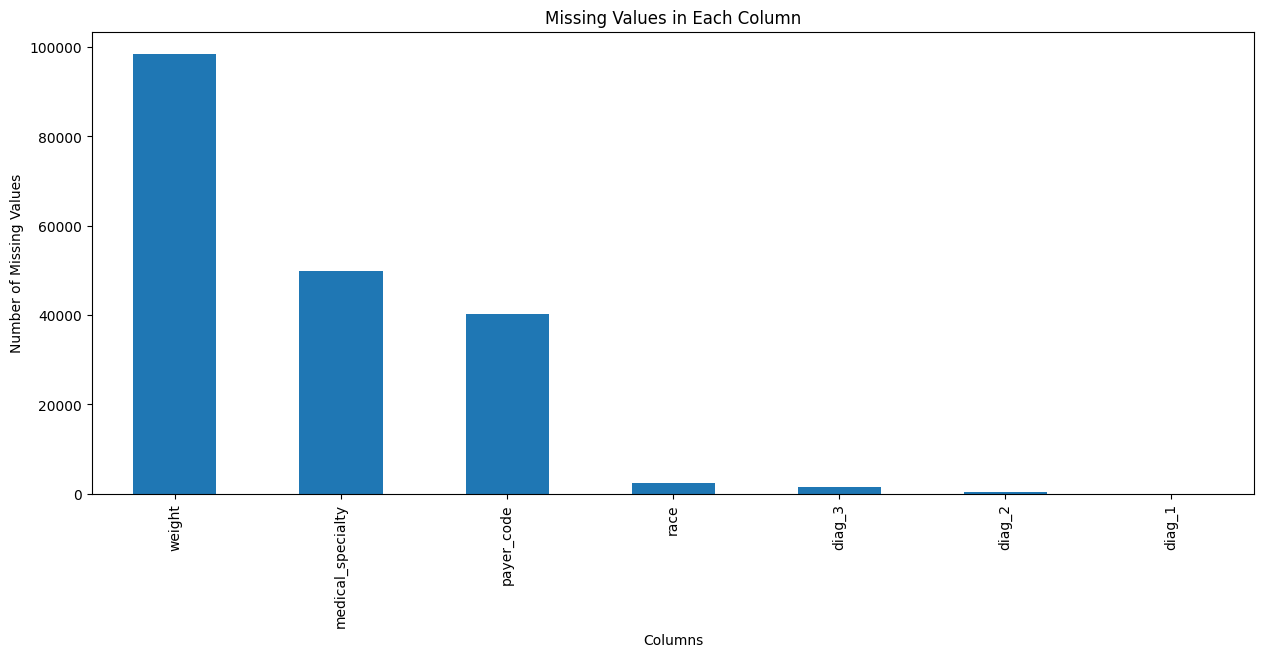

In [ ]:
# -- Checking for missing values for each columns
# -- since there are many "?" in the raw data, let's deal with it first
# -- Replace '?' with NaN for clearer handling of missing data
dia_cleaned = dia.replace('?', pd.NA)

# -- Count the number of missing values in each column
missing_values = dia_cleaned.isna().sum()

# -- Print the missing values
print("Missing Values Count:\n", missing_values.sort_values(ascending=False))

# --Plotting the missing values
plt.figure(figsize=(15, 6))
missing_values[missing_values > 0].sort_values(ascending=False).plot(kind='bar')
plt.title('Missing Values in Each Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.show()

The missing values in the dataset have been calculated and plotted. Here are the key observations:

Significant Missing Data: The weight column has the most missing values (98,569), followed by medical_specialty (49,949), and payer_code (40,256).

Moderate Missing Values: Columns like race, diag_3, and diag_2 have a moderate number of missing values.

Minor Missing Values: diag_1 has a relatively small number of missing values (21).

In [ ]:

# -- print the unique value of payer code
dia["payer_code"].unique()

array(['?', 'MC', 'MD', 'HM', 'UN', 'BC', 'SP', 'CP', 'SI', 'DM', 'CM',
       'CH', 'PO', 'WC', 'OT', 'OG', 'MP', 'FR'], dtype=object)

In [ ]:
# -- print the unique value of payer code
dia["medical_specialty"].unique()

array(['Pediatrics-Endocrinology', '?', 'InternalMedicine',
       'Family/GeneralPractice', 'Cardiology', 'Surgery-General',
       'Orthopedics', 'Gastroenterology',
       'Surgery-Cardiovascular/Thoracic', 'Nephrology',
       'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma',
       'Pulmonology', 'Surgery-Neuro',
       'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology',
       'Pediatrics', 'Hematology/Oncology', 'Otolaryngology',
       'Surgery-Colon&Rectal', 'Pediatrics-CriticalCare', 'Endocrinology',
       'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology',
       'Neurology', 'Anesthesiology-Pediatric', 'Radiology',
       'Pediatrics-Hematology-Oncology', 'Psychology', 'Podiatry',
       'Gynecology', 'Oncology', 'Pediatrics-Neurology',
       'Surgery-Plastic', 'Surgery-Thoracic',
       'Surgery-PlasticwithinHeadandNeck', 'Ophthalmology',
       'Surgery-Pediatric', 'Pediatrics-EmergencyMedicine',
       'PhysicalMedicineandRe

In [ ]:
# -- dropping columns with large number of missing values
dia_cleaned = dia_cleaned.drop(['weight'], axis = 1)

In [ ]:
# -- replacing nan to unknown
dia_cleaned["payer_code"] = dia_cleaned["payer_code"].fillna("UNK")
dia_cleaned["medical_specialty"] = dia_cleaned["medical_specialty"].fillna("UNK")

# -- also same for the race
dia_cleaned["race"] = dia_cleaned["race"].fillna("UNK")


I only dropped weight since it consists almost 90% null values. For the medical_specialty, considering it reflect the various health condition for each patient, I would like to replace "?" to unknown value and use this as a categorical data to do the prediction. Also for payer_code, since it somehow refects the medical level for different geo location, I will also keep it.

In [ ]:
dia_cleaned.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [ ]:
# -- remove samples are related to death or hospice
dia_cleaned = dia_cleaned.loc[~dia_cleaned.discharge_disposition_id.isin([11,13,14,19,20,21])]

since for the discharge_disposition_id, 11,13,14,19,20,21 are related to death or hospice, we also need to remove these samples since they cannot be readmitted

**dependent feature**

In [ ]:
# -- check the distribution of readmissions
dia_cleaned.groupby("readmitted").size()

readmitted
<30    11314
>30    35502
NO     52527
dtype: int64

The above results tell us if a patient was hospitalized within 30 days, greater than 30 days or not readmitted. Therefore, simply using "yes" or "no" as the dependent variable has the imbalanced dataset problem. But I will handle this later.

In [ ]:
# -- turn it to dummy variable
dia_cleaned['readmitted'] = dia_cleaned['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)


<ipython-input-136-8312841a6885>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dia_cleaned['readmitted'] = dia_cleaned['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)


# Feature selection

We have preliminarily cleaned the dataset. Now, let's conduct a more thorough analysis of the columns to select the most relevant features for our study.

In [ ]:
# -- let's check the nan value foe each column
dia_cleaned.isna().sum().sort_values(ascending=False)

diag_3                      1419
diag_2                       356
diag_1                        20
encounter_id                   0
chlorpropamide                 0
acetohexamide                  0
glipizide                      0
glyburide                      0
tolbutamide                    0
pioglitazone                   0
rosiglitazone                  0
acarbose                       0
miglitol                       0
troglitazone                   0
tolazamide                     0
examide                        0
citoglipton                    0
insulin                        0
glyburide-metformin            0
glipizide-metformin            0
glimepiride-pioglitazone       0
metformin-rosiglitazone        0
metformin-pioglitazone         0
change                         0
diabetesMed                    0
glimepiride                    0
repaglinide                    0
nateglinide                    0
patient_nbr                    0
race                           0
gender    

we find the numerical data in here has no missing values, therefore, we would like to plot the distirbution of each of them.

**this is for numerical columns**

***age***

In [ ]:
# -- print the distribution of age
dia_cleaned.groupby("age").size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

There are various approaches to handling the age data in our dataset. One option is to consolidate it into fewer categories. However, for our analysis, I prefer to retain the original structure of the raw data to assess the impact of age on readmissions. Consequently, I will divide age into 10 distinct categories. For instance, the [0-10] age range will be represented by 0.

In [ ]:
# -- Creating a dictionary for age mapping
age_mapping = {
    '[0-10)': 0,
    '[10-20)': 10,
    '[20-30)': 20,
    '[30-40)': 30,
    '[40-50)': 40,
    '[50-60)': 50,
    '[60-70)': 60,
    '[70-80)': 70,
    '[80-90)': 80,
    '[90-100)': 90
}

# -- Apply the mapping using the map() function
dia_cleaned['age_mapped'] = dia_cleaned['age'].map(age_mapping)


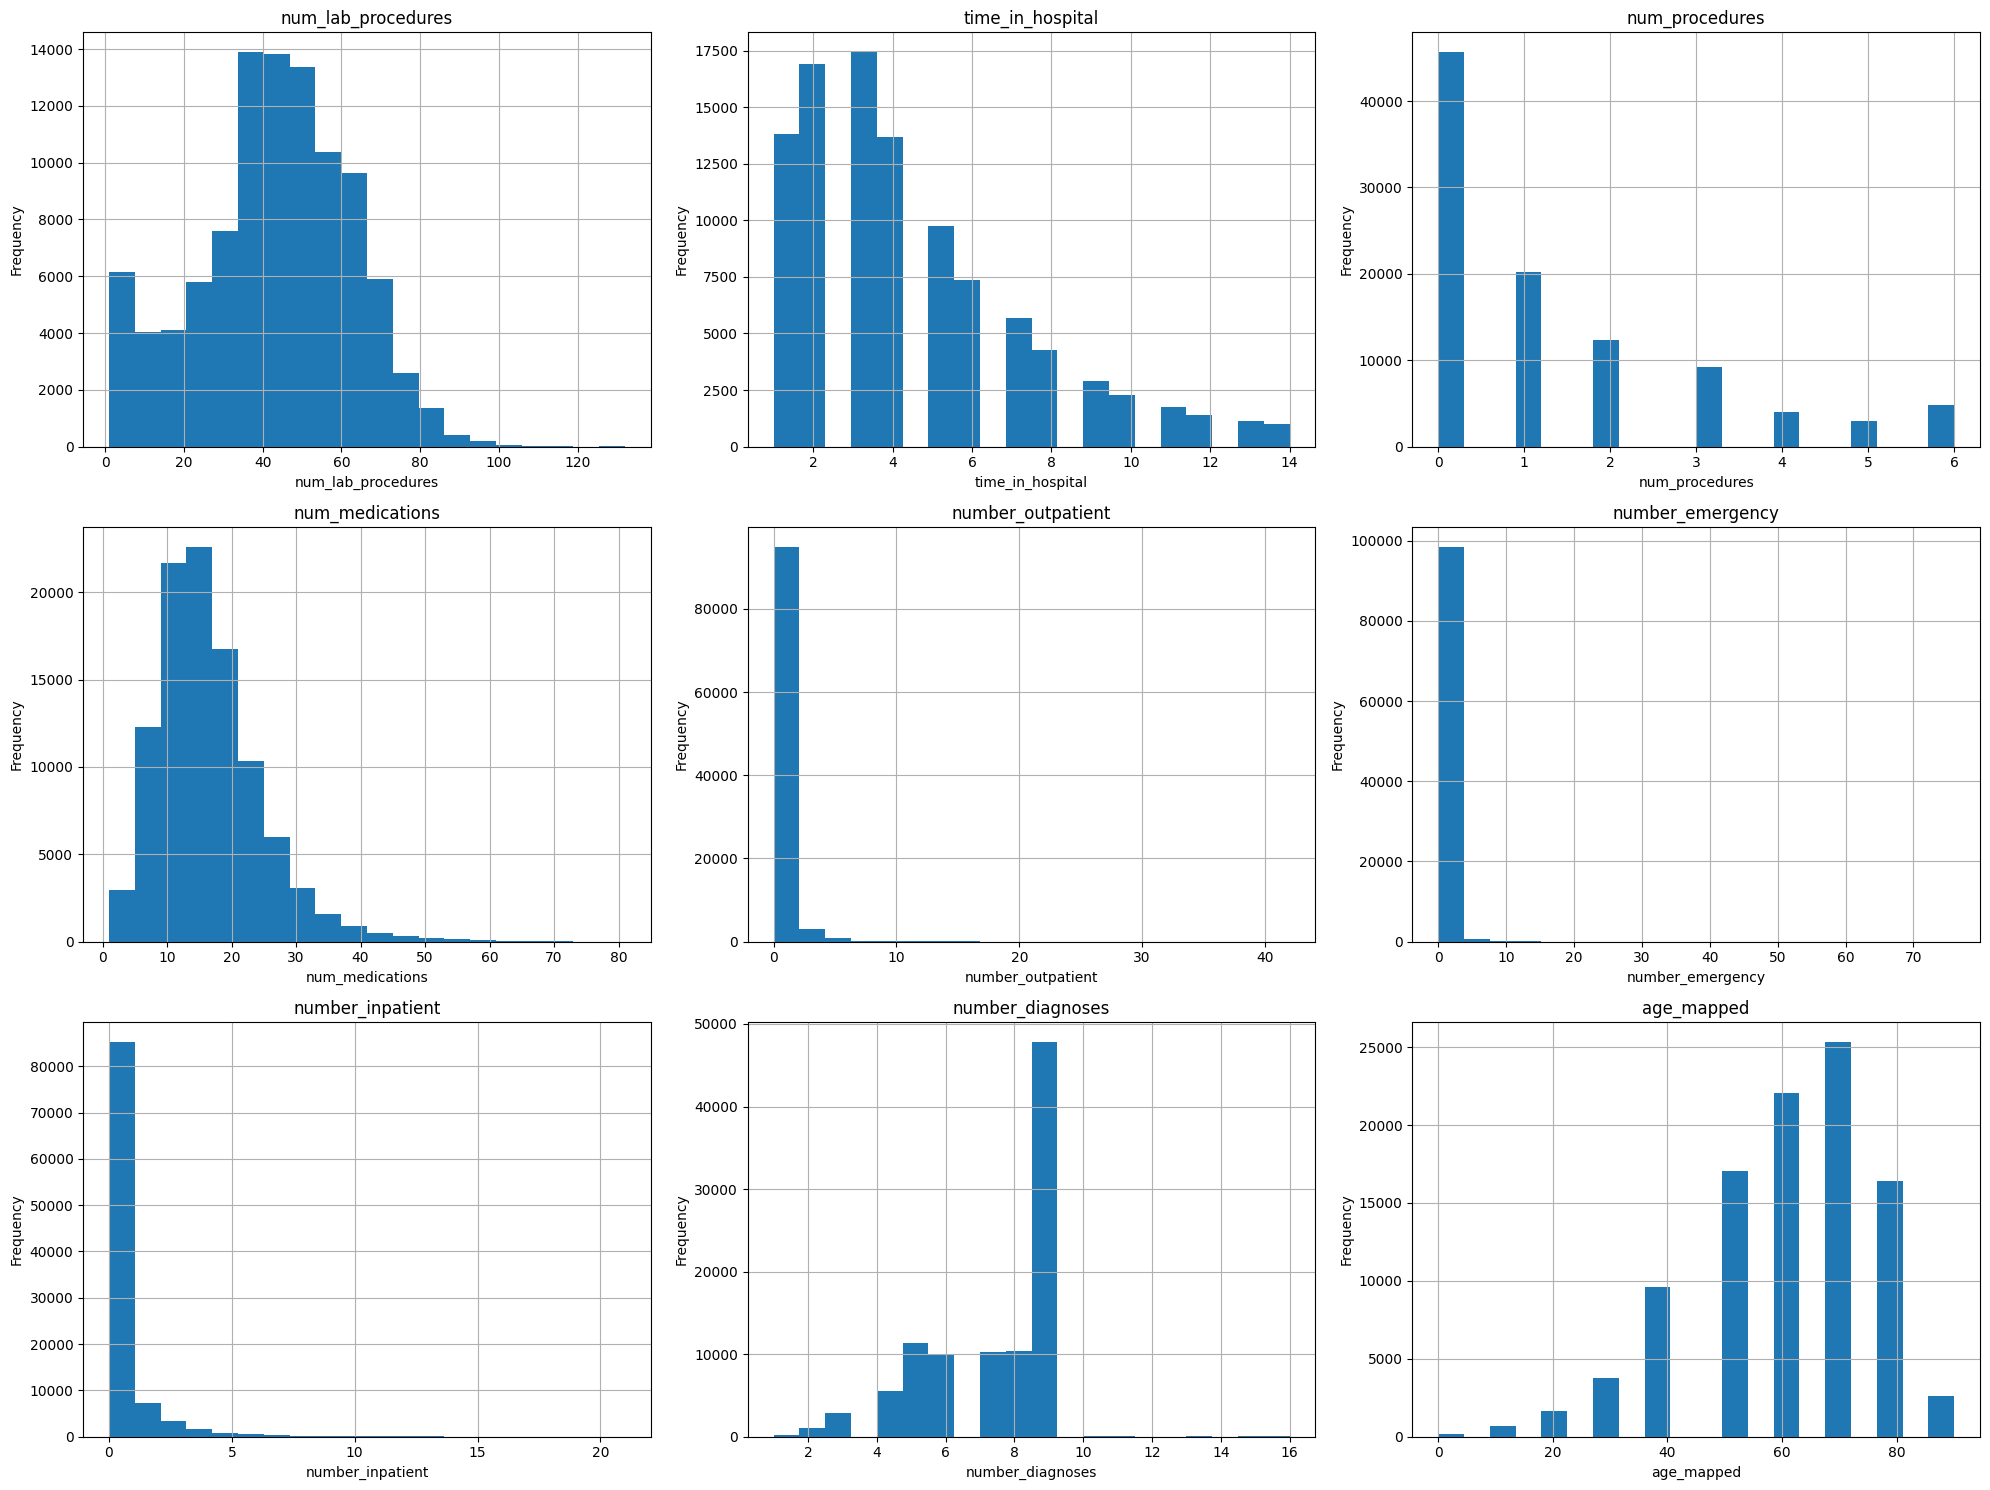

       num_lab_procedures  time_in_hospital  num_procedures  num_medications  \
count        99343.000000      99343.000000    99343.000000     99343.000000   
mean            42.906929          4.379332        1.334236        15.979062   
std             19.610032          2.968409        1.702786         8.094909   
min              1.000000          1.000000        0.000000         1.000000   
25%             31.000000          2.000000        0.000000        10.000000   
50%             44.000000          4.000000        1.000000        15.000000   
75%             57.000000          6.000000        2.000000        20.000000   
max            132.000000         14.000000        6.000000        81.000000   

       number_outpatient  number_emergency  number_inpatient  \
count       99343.000000      99343.000000      99343.000000   
mean            0.369246          0.198444          0.630935   
std             1.265142          0.937734          1.260428   
min             0.00000

In [ ]:
num_cols = ["num_lab_procedures", "time_in_hospital", "num_procedures",
       "num_medications", "number_outpatient", "number_emergency",
       "number_inpatient", "number_diagnoses", "age_mapped"]

# Plotting histograms for each specified numerical column
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    dia_cleaned[col].hist(bins=20)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Displaying an overview of these numerical columns
print(dia_cleaned[num_cols].describe())

according to the printed results above, numerical columns above are clean and ready to use

**this part is for the categorical features**

***medical_specialty***

In [ ]:
# -- print the num and the unique value for medical_specialty
dia_cleaned.groupby("medical_specialty").size().sort_values(ascending = False)

medical_specialty
UNK                                 48616
InternalMedicine                    14237
Emergency/Trauma                     7419
Family/GeneralPractice               7252
Cardiology                           5279
                                    ...  
Surgery-PlasticwithinHeadandNeck        1
Dermatology                             1
Proctology                              1
Psychiatry-Addictive                    1
Speech                                  1
Length: 73, dtype: int64

It seems most of patients are unknown and the count drop off pretty quicky. We dont need to do one-hot-encoding for all of them, so I would like to keep the first 10.

In [ ]:
# --select features for one-hot-encoding
medical_specialty = dia_cleaned.groupby("medical_specialty").size().sort_values(ascending = False)[:10]
spec_cols = medical_specialty.index.values
spec_cols

# -- make a new column with duplicated data
dia_cleaned["med_spec"] = dia_cleaned["medical_specialty"].copy()

# -- replace the rest of specialities not in top 10 with 'other' category
dia_cleaned.loc[~dia_cleaned.med_spec.isin(spec_cols), 'med_spec'] = 'other'

# -- print the result
dia_cleaned.groupby("med_spec").size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Radiologist                    1121
Surgery-General                3059
UNK                           48616
other                          8199
dtype: int64

***gender***

In [ ]:
# -- check the distribution of gender
print(dia_cleaned.groupby("gender").size())

# -- drop rows that gender == unknown
dia_cleaned = dia_cleaned[dia_cleaned['gender'] != 'Unknown/Invalid'].reset_index()

gender
Female             53454
Male               45886
Unknown/Invalid        3
dtype: int64


I have decided to remove rows with the gender marked as 'unknown' because they only account for 3 patients. Considering the overall size of the dataset, excluding these few entries will be more appropriate for maintaining data integrity and accuracy in our analysis

In [ ]:
# -- add categorical data and implement one hot encoding
cate_cols = ["admission_type_id", "discharge_disposition_id", "admission_source_id", "race", "gender"]
dia_cleaned[cate_cols] = dia_cleaned[cate_cols].astype("str")

dia_cleaned = pd.get_dummies(dia_cleaned[cate_cols + num_cols + ["med_spec"]+ ["readmitted"]], drop_first = True)

In [ ]:
# -- standardize numerical cols
scaler  = StandardScaler()
# Fit and transform the data
dia_cleaned[num_cols] = scaler.fit_transform(dia_cleaned[num_cols])

In [ ]:
# -- check the nan value
dia_cleaned.isna().sum().sort_values(ascending=False)

num_lab_procedures             0
admission_source_id_22         0
admission_source_id_7          0
admission_source_id_6          0
admission_source_id_5          0
                              ..
discharge_disposition_id_28    0
discharge_disposition_id_3     0
discharge_disposition_id_4     0
discharge_disposition_id_5     0
med_spec_other                 0
Length: 69, dtype: int64

In [ ]:
# -- check the features that we have included
dia_cleaned.columns

Index(['num_lab_procedures', 'time_in_hospital', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age_mapped', 'readmitted',
       'admission_type_id_2', 'admission_type_id_3', 'admission_type_id_4',
       'admission_type_id_5', 'admission_type_id_6', 'admission_type_id_7',
       'admission_type_id_8', 'discharge_disposition_id_10',
       'discharge_disposition_id_12', 'discharge_disposition_id_15',
       'discharge_disposition_id_16', 'discharge_disposition_id_17',
       'discharge_disposition_id_18', 'discharge_disposition_id_2',
       'discharge_disposition_id_22', 'discharge_disposition_id_23',
       'discharge_disposition_id_24', 'discharge_disposition_id_25',
       'discharge_disposition_id_27', 'discharge_disposition_id_28',
       'discharge_disposition_id_3', 'discharge_disposition_id_4',
       'discharge_disposition_id_5', 'discharge_disposition_id_6',
       'discharge_disposition_i

At this point, I did not include any medicine since that part need further medicine research and analysis. I will do that in the future, but now lets see how it works with the current features.  

# Building training/testing samples

In [ ]:

from sklearn.model_selection import train_test_split

feature_x = dia_cleaned.columns[dia_cleaned.columns != "readmitted"]
X = dia_cleaned[feature_x]
y = dia_cleaned["readmitted"]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply balancing techniques to X_train and y_train here
# For example, using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)



# Model selection

**KNN**

In [ ]:
# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=100)

# Train the model
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)
y_pred_train = knn.predict(X_train)


# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.6351419367827662
Test Accuracy: 0.6264344674854037


**Logistic regression**

In [ ]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Predict on the test set and the training set
y_pred_test = log_reg.predict(X_test)
y_pred_train = log_reg.predict(X_train)

# Calculate accuracy for both sets
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")

# Additional metrics for test set
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

Training Accuracy: 0.6250754982887055
Test Accuracy: 0.6289510771089188
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.77      0.69     10536
           1       0.64      0.47      0.54      9332

    accuracy                           0.63     19868
   macro avg       0.63      0.62      0.62     19868
weighted avg       0.63      0.63      0.62     19868

Confusion Matrix:
[[8089 2447]
 [4925 4407]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**RandomForestClassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# -- select the parameter(s) to tune and the values to try
tuned_parameters = [{"min_samples_leaf" : [1, 2, 5, 10, 15, 20, 30, 50, 100, 200]}]

# -- perform Grid Search
rd_tune = RandomForestClassifier(random_state=667)
cv_tune = GridSearchCV(rd_tune, tuned_parameters)
cv_tune.fit(X_train, y_train);


In [ ]:
# "Predict" the training data
y_pred_rf_train = cv_tune.predict(X_train)

# "Predict" the test data
y_pred_rf = cv_tune.predict(X_test)

# Calculate accuracy for both sets
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)

accuracy_test_rf, accuracy_train_rf


(0.6223072277028388, 0.9996099255083551)

It is obvious that our random forest regressor model has the overfitting problem

In [ ]:
# Retrieving feature importance for each model

# K-Nearest Neighbors does not provide direct feature importance
# Thus, we will only retrieve for Logistic Regression and Random Forest

# Feature importance for Logistic Regression
# Coefficients as feature importance
logreg_importance = log_reg.coef_[0]

# Feature importance for Random Forest
# GridSearchCV object
best_model = cv_tune.best_estimator_

# Now you can access the feature_importances_ attribute (if the underlying model supports it)
rf_importance = best_model.feature_importances_

# Creating a DataFrame for better visualization
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Logistic Regression': logreg_importance,
    'Random Forest': rf_importance
})


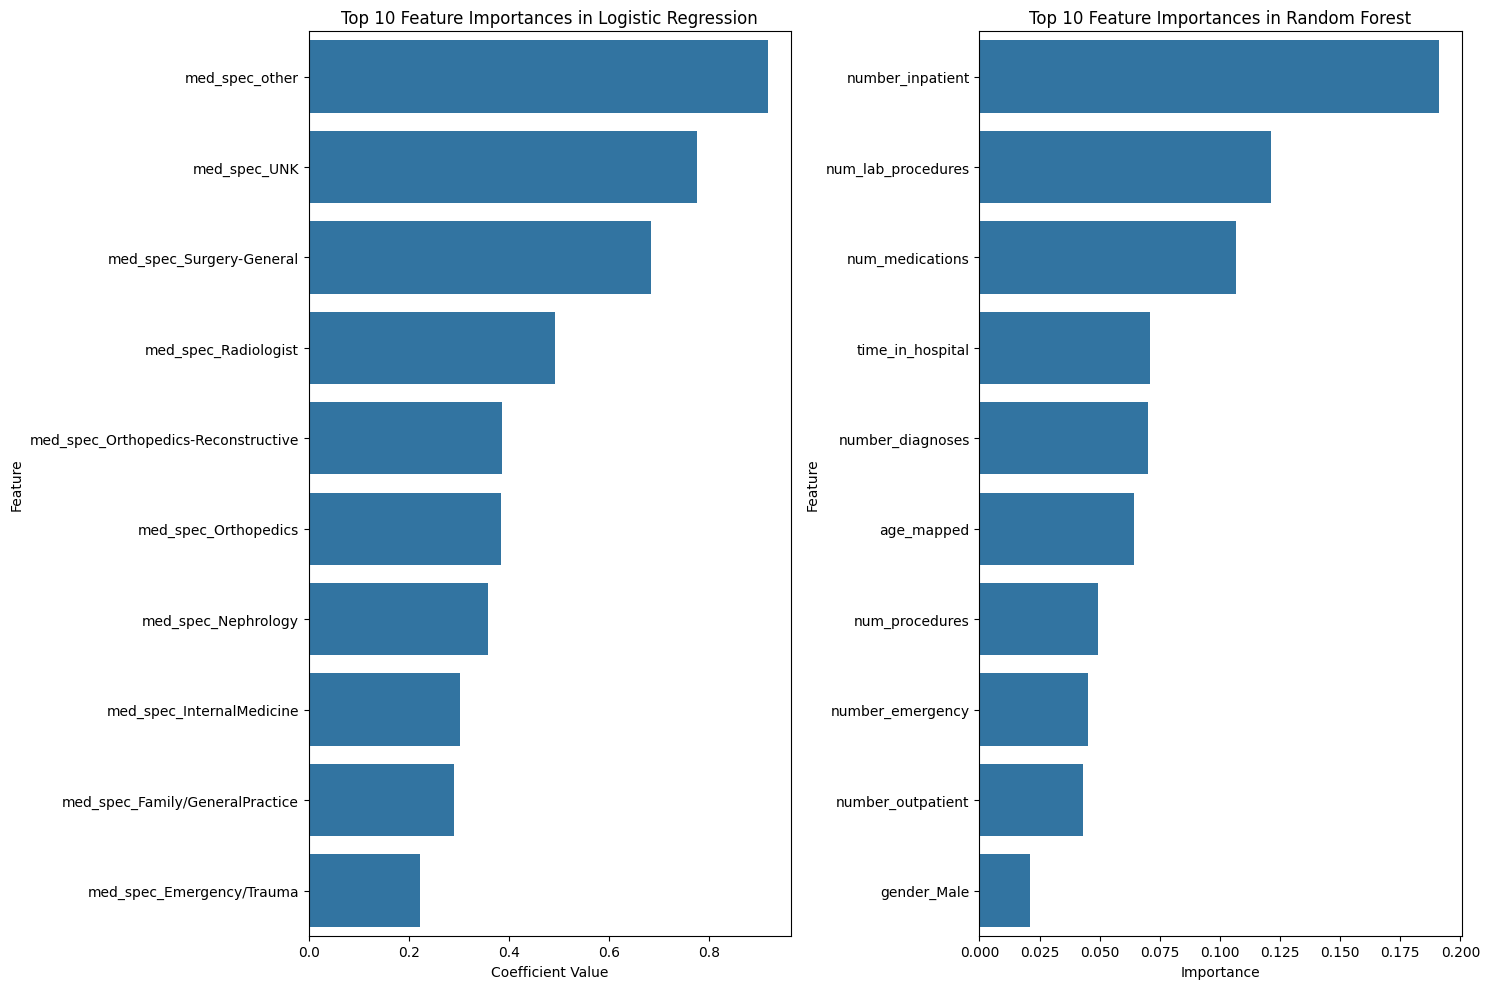

In [ ]:

# Sorting the DataFrame for better visualization for Logistic Regression
importance_df.sort_values(by='Logistic Regression', ascending=False, inplace=True)

# Setting up the matplotlib figure
plt.figure(figsize=(15, 10))

# First subplot for Logistic Regression
plt.subplot(1, 2, 1)
sns.barplot(x='Logistic Regression', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

importance_df.sort_values(by='Random Forest', ascending=False, inplace=True)
# Second subplot for Random Forest
plt.subplot(1, 2, 2)
sns.barplot(x='Random Forest', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

After visualizing the results, I observed that the feature importance varies between each model. While the feature importance differs and the accuracy is not high, it's important to note that this is my initial attempt at evaluating Medicare data. With additional time and analysis, I plan to undertake the following steps:"

1. Select medical categorical features informed by a thorough literature review.
2. Exclude features such as payer location for specific tests.
3. Transition from using classification models to regression models, establishing a threshold for predictions.
